In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import torch.utils.data as data
import torch
from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset

import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator #PygNodePropPredDatase

from IPython.display import clear_output
import wandb

In [2]:
# Read files
path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
df_train = pd.read_csv(path + "train_set.csv") 
df_test = pd.read_csv(path + "test_set.csv")
df_train_edges = pd.read_csv(path + "train_edges.csv")
df_test_edges = pd.read_csv(path + "test_edges.csv")

In [3]:
# AIXO JA NO HAURIA DE CALDRE, ESTA AL DATA SPLIT
# path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
# df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
# df_edges_init = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
# df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

# # Change column names of df_features
# colNames1 = {'0': 'txId', 1: "Time step"}
# colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
# colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

# colNames = dict(colNames1, **colNames2, **colNames3 )
# colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

# df_features = df_features.rename(columns=colNames)

In [4]:
# AIXO JA NO HAURIA DE CALDRE, ESTA AL DATA SPLIT
#  def prep_df(feats: pd.DataFrame, edges: pd.DataFrame):
#     #1 és la classe illicit, 2 la  licit
#     df_feats = feats.loc[feats['class'].isin([1, 2])]
#     df_feats['class'] = df_feats['class'].replace({1: 0, 2: 1})
#     df_feats = df_feats.reset_index(drop=True)

#     #ens quedem només amb els edges que apareixen en el nodes d'entrenament
#     df_edges = edges.loc[((edges['txId1'].isin(df_feats['txId'])) & (df_edges_init['txId2'].isin(df_feats['txId'])))]
#     df_edges = df_edges.reset_index(drop=True)
#     print(f"contador de valors per classe: \n {df_feats['class'].value_counts()}\n")
#     return  df_feats, df_edges

# df_train, df_edges_train = prep_df(df_train_init, df_edges_init)
# df_test, df_edges_test = prep_df(df_test_init, df_edges_init)

contador de valors per classe: 
 class
1    34654
0     2672
Name: count, dtype: int64

contador de valors per classe: 
 class
1    7365
0    1873
Name: count, dtype: int64



C:\Users\gsamp\AppData\Local\Temp\ipykernel_924\1761167425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feats['class'] = df_feats['class'].replace({1: 0, 2: 1})


In [5]:
def map_idx(feats: pd.DataFrame, edges: pd.DataFrame, save = True, loading_dir = "a"):
    mapping_txid = dict(zip(feats['txId'], list(feats.index)))
    dir = 'dades_guillem/' + str(loading_dir) + '.pkl'
    if save:
        df_edges_mapped = edges.replace({'txId1': mapping_txid, 'txId2': mapping_txid})
        
        df_edges_mapped.to_pickle(loading_dir)
    else:
        df_edges_mapped = pd.read_pickle(loading_dir)
    return df_edges_mapped

df_edges_mapped_train = map_idx(feats = df_train, edges = df_train_edges, save = True, loading_dir='train')
df_edges_mapped_test = map_idx(feats = df_test, edges = df_test_edges, save = True, loading_dir='train') # Això no hauria de ser test?


In [6]:
def get_data(feats: pd.DataFrame, edges:pd.DataFrame):
    x = torch.tensor(feats.drop(columns=['class', 'Time Step', 'txId']).values, dtype=torch.float)
    edge_index = torch.tensor(edges.values, dtype=torch.long).T
    y = torch.tensor(feats['class'].values)
    time = torch.tensor(feats['Time Step'].values)
    data = Data(x=x, edge_index=edge_index, y=y, time=time)
    return data


train_data = get_data(df_train, df_edges_mapped_train)
test_data = get_data(df_test, df_edges_mapped_test)

In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels,
                 hidden_channels, out_channels,
                 n_layers=2):
        
        super(SAGE, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        self.layers_bn = torch.nn.ModuleList()
        if n_layers == 1:
            self.layers.append(SAGEConv(in_channels, out_channels,   normalize=False))
        elif n_layers == 2:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
            # self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        else:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            # self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(n_layers - 2):
            self.layers.append(SAGEConv(hidden_channels,  hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
                    
                
        if n_layers != 1:
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        
        for layer in self.layers:
            layer.reset_parameters()
            
            
            
    def forward(self, x, edge_index):
        if len(self.layers) > 1:
            looper = self.layers[:-1]
        else:
            looper = self.layers
        
        for i, layer in enumerate(looper):
            x = layer(x, edge_index)
            # print(f"SHAPE: {x.shape}, step: {i}")
            # print(f"Step: {i}")
            try:
                x = self.layers_bn[i](x)
            except Exception as e:
                abs(1)
            finally:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        
        if len(self.layers) > 1:
            x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=-1), torch.var(x)
    
    def inference(self, total_loader, device):
        xs = []
        var_ = []
        for batch in total_loader:
            out, var = self.forward(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            xs.append(out.cpu())
            var_.append(var.item())
        
        out_all = torch.cat(xs, dim=0)
        
        return out_all, var_

In [8]:
EPOCHS = 101
layers_list = [4, 5]
# layers_list = [4]
wb = True
for LAYERS in layers_list:
    model = SAGE(train_data.x.shape[1], 256, torch.unique(train_data.y).size(0), n_layers=LAYERS)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)
    criterion = torch.nn.CrossEntropyLoss()
    if wb:
        wandb.init(
            # set the wandb project where this run will be logged
            project="GraphAnomaly",
            name = f"2_SAGE - n_layers: {LAYERS}",
            # track hyperparameters and run metadata
            config={
            "architecture": "SAGE_3",
            "dataset": "Time Steps elliptic",
            "epochs": EPOCHS,
            "layers": LAYERS
            }
        )

    def train(data, epoch):
        optimizer.zero_grad()  # Clear gradients.
        out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
        pred = out.argmax(dim=1)
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        
        # Calculate accuracy
        correct = pred.eq(data.y).sum().item()
        total = len(data.y)
        accuracy = correct / total
        
        if wb:
            wandb.log({
                "epoch": epoch,
                "train_loss": loss,
                "train_accuracy": accuracy,
            })
        if epoch%5 == 0:
            max_value = torch.max(pred)
            counts = torch.bincount(pred, minlength=max_value.item() + 1)
            print(f"""Nodes classified as fraud: {counts[0]}, 
                nodes classified as licit: {counts[1]}""")
            
            
        return loss, accuracy

    def test(data, epoch):
        model.eval()  # Set the model to evaluation mode.
        with torch.no_grad():
            out, _ = model(data.x, data.edge_index)  # Perform a forward pass.
            loss = criterion(out, data.y)
            
            pred = out.argmax(dim=1)  # Get the predicted labels by selecting the class with the highest probability.
            # Calculate accuracy
            correct = pred.eq(data.y).sum().item()
            total = len(data.y)
            accuracy = correct / total
            
            #precision, recall, f1 score
            precision = precision_score(data.y.cpu().numpy(), pred.cpu().numpy(), average=None)
            recall = recall_score(data.y.cpu().numpy(), pred.cpu().numpy(), average=None)
            f1 = f1_score(data.y.cpu().numpy(), pred.cpu().numpy(), average=None)
            
            other_metrics = [precision, recall, f1]
            if wb:
                wandb.log({
                "epoch": epoch,
                "test_loss": loss,
                "test_accuracy": accuracy,
                "test_precision_class_0": precision[0],
                "test_precision_class_1": precision[1],
                "test_recall_class_0": recall[0],
                "test_recall_class_1": recall[1],
                "test_f1_score_class_0": f1[0],
                "test_f1_score_class_1": f1[1]
            })
            
        return loss, accuracy, other_metrics
            
        
        
    train_loss_history = []
    test_loss_history = []
    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train(train_data, epoch)
        train_loss_history.append(train_loss.detach().numpy())
        train_acc_hist.append(train_acc)
        
        test_loss, test_acc, metrics = test(test_data, epoch)
        test_loss_history.append(test_loss.detach().numpy())
        test_acc_hist.append(test_acc)
        
        if epoch%5 == 0:
            print(f"""Epoch: {epoch}, 
            Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}
            Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}
            """)
            
            print(f"Precision: {metrics[0]}, Recall: {metrics[1]}, F1 Score: {metrics[2]} \n")
            print("---------------------------------------------------------------------------------")
        

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gsamper. Use `wandb login --relogin` to force relogin


Nodes classified as fraud: 12192, 
                nodes classified as licit: 25134
Epoch: 0, 
            Training Loss: 0.7475, Training Accuracy: 0.6355
            Test Loss: 16.7325, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 3514, 
                nodes classified as licit: 33812
Epoch: 5, 
            Training Loss: 0.6259, Training Accuracy: 0.8432
            Test Loss: 0.9246, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 10, 
            Training Loss: 0.2455, Training Accuracy: 0.9284
            Test Loss: 0.5334, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 15, 
            Training Loss: 0.2296, Training Accuracy: 0.9284
            Test Loss: 0.5024, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 20, 
            Training Loss: 0.2062, Training Accuracy: 0.9284
            Test Loss: 0.5046, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 25, 
            Training Loss: 0.1872, Training Accuracy: 0.9284
            Test Loss: 0.4440, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 30, 
            Training Loss: 0.1747, Training Accuracy: 0.9284
            Test Loss: 0.4244, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 35, 
            Training Loss: 0.1636, Training Accuracy: 0.9284
            Test Loss: 0.4138, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 40, 
            Training Loss: 0.1529, Training Accuracy: 0.9284
            Test Loss: 0.4148, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 45, 
            Training Loss: 0.1431, Training Accuracy: 0.9284
            Test Loss: 0.4149, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 50, 
            Training Loss: 0.1348, Training Accuracy: 0.9284
            Test Loss: 0.4177, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 55, 
            Training Loss: 0.1270, Training Accuracy: 0.9284
            Test Loss: 0.4041, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 60, 
            Training Loss: 0.1181, Training Accuracy: 0.9284
            Test Loss: 0.4134, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 1827, 
                nodes classified as licit: 35499
Epoch: 65, 
            Training Loss: 0.1092, Training Accuracy: 0.9639
            Test Loss: 0.4209, Test Accuracy: 0.9100
            
Precision: [0.87973761 0.91533181], Recall: [0.64442072 0.97759674], F1 Score: [0.74391371 0.94544022] 

---------------------------------------------------------------------------------
Nodes classified as fraud: 1762, 
                nodes classified as licit: 35564
Epoch: 70, 
            Training Loss: 0.1007, Training Accuracy: 0.9658
            Test Loss: 0.4061, Test Accuracy: 0.9102
            
Precision: [0.86647927 0.91810621], Recall: [0.65830219 0.97420231], F1 Score: [0.74817961 0.94532279] 

---------------------------------------------------------------------------------
Nodes classified as fraud: 2093, 
                nodes classified as licit: 35233
Epoch: 75, 
            Training Loss: 0.0945, Training Accuracy: 0.9655
            Test Loss: 0.4

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▇▇▇▇▇▇▇▇▇▇███
test_f1_score_class_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇████
test_f1_score_class_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▇▆▇▆▇▇▇▇▇▇███
test_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_precision_class_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████▇▇▇██████▇█
test_precision_class_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▆▆▇▇▇▇▇▇▇▇███
test_recall_class_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▆▆▇▇▇▇▇▇▇▇███
test_recall_class_1,█████████████████████████▄▅▅▄▃▁▂▃▄▄▄▃▂▂▂
train_accuracy,▁▇▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▄▇▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


Nodes classified as fraud: 16220, 
                nodes classified as licit: 21106
Epoch: 0, 
            Training Loss: 0.7189, Training Accuracy: 0.5536
            Test Loss: 24.9634, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 5, 
            Training Loss: 0.3256, Training Accuracy: 0.9284
            Test Loss: 0.7002, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 10, 
            Training Loss: 0.2941, Training Accuracy: 0.9284
            Test Loss: 0.4446, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 15, 
            Training Loss: 0.1867, Training Accuracy: 0.9284
            Test Loss: 0.4615, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 20, 
            Training Loss: 0.1694, Training Accuracy: 0.9284
            Test Loss: 0.4494, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 25, 
            Training Loss: 0.1587, Training Accuracy: 0.9284
            Test Loss: 0.4180, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 30, 
            Training Loss: 0.1485, Training Accuracy: 0.9284
            Test Loss: 0.4195, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 35, 
            Training Loss: 0.1405, Training Accuracy: 0.9284
            Test Loss: 0.4714, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Nodes classified as fraud: 0, 
                nodes classified as licit: 37326
Epoch: 40, 
            Training Loss: 0.1316, Training Accuracy: 0.9284
            Test Loss: 0.4777, Test Accuracy: 0.7973
            
Precision: [0.         0.79725049], Recall: [0. 1.], F1 Score: [0.         0.88718906] 

---------------------------------------------------------------------------------


c:\Users\gsamp\anaconda3\envs\visionEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Nodes classified as fraud: 18, 
                nodes classified as licit: 37308
Epoch: 45, 
            Training Loss: 0.1236, Training Accuracy: 0.9286
            Test Loss: 0.4818, Test Accuracy: 0.7980
            
Precision: [0.70588235 0.79817807], Recall: [0.00640683 0.99932111], F1 Score: [0.01269841 0.88749548] 

---------------------------------------------------------------------------------
Nodes classified as fraud: 72, 
                nodes classified as licit: 37254
Epoch: 50, 
            Training Loss: 0.1176, Training Accuracy: 0.9295
            Test Loss: 0.5355, Test Accuracy: 0.7997
            
Precision: [0.82857143 0.79963056], Recall: [0.01548318 0.99918534], F1 Score: [0.03039832 0.88833897] 

---------------------------------------------------------------------------------
Nodes classified as fraud: 93, 
                nodes classified as licit: 37233
Epoch: 55, 
            Training Loss: 0.1119, Training Accuracy: 0.9302
            Test Loss: 0.5668, T

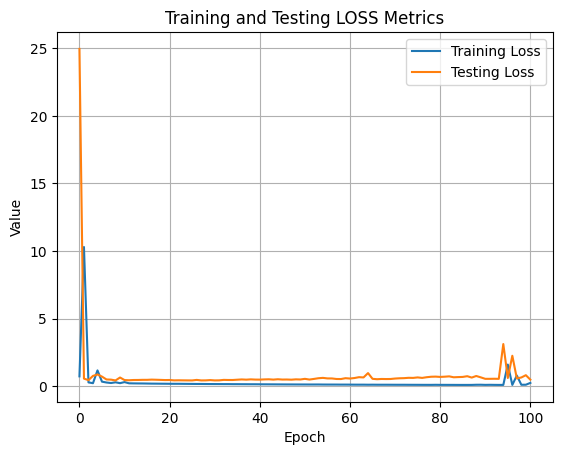

In [9]:
plt.plot([e for e in range(EPOCHS)], train_loss_history, label='Training Loss')
plt.plot([e for e in range(EPOCHS)], test_loss_history, label='Testing Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Testing LOSS Metrics')
plt.legend()
plt.grid(True)
plt.show()

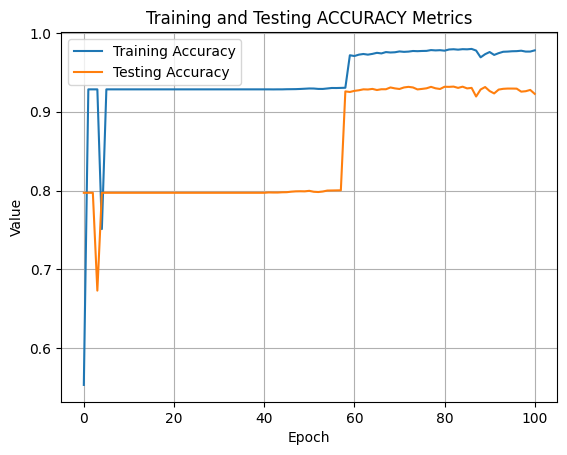

In [10]:
plt.plot([e for e in range(EPOCHS)], train_acc_hist, label='Training Accuracy')
plt.plot([e for e in range(EPOCHS)], test_acc_hist, label='Testing Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Testing ACCURACY Metrics')
plt.legend()
plt.grid(True)
plt.show()